# Changing $p(x)$

The simplest case we consider is a linear trend in where we are sampling the data over time. For this, we have to make a slight change to how we generate the data since previously we were sampling $p(x|y)$ from Gaussian distributions, but now we will sample $p(x)$ independently, and then sample $p(y|x)$.

Perhaps generating x then p(y|x) does not make sense since our data is then no longer

In [1]:
import copy
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import eval_model, perturb_labels_fp, update_model_feedback_linear_trend, update_model_feedback, make_trend_gaussian_data

%matplotlib inline

In [10]:
def train_update_loop(n_train, n_update, n_test, m0, m1, s0, s1, n_features, uniform_range, offset, seeds):
    seeds = np.arange(seeds)
    
    results = {"initial_orig_data_fprs": [], "initial_shifted_data_fprs": [], "updated_with_trend_on_orig_data_fprs": [], 
               "updated_with_trend_on_shifted_data_fprs": [], "updated_no_trend_on_orig_data_fprs": [], "updated_no_trend_on_shifted_data_fprs": []}

    for seed in seeds:
        np.random.seed(seed)

        x_train, y_train = make_trend_gaussian_data(m0, m1, s0, s1, n_train, n_features, uniform_range)
        x_update, y_update = make_trend_gaussian_data(m0, m1, s0, s1, n_update, n_features, uniform_range)
        x_test_orig, y_test_orig = make_trend_gaussian_data(m0, m1, s0, s1, n_test, n_features, uniform_range)
        x_test_shifted, y_test_shifted = make_trend_gaussian_data(m0, m1, s0, s1, n_test, n_features, [uniform_range[0] + offset, uniform_range[1]])

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test_orig)
        initial_orig_tnr, initial_orig_fpr, initial_orig_fnr, initial_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = model.predict(x_test_shifted)
        initial_shifted_tnr, initial_shifted_fpr, initial_shifted_fnr, initial_shifted_tpr = eval_model(y_test_shifted, y_pred)

        new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 100, intermediate=False)

        y_pred = new_model.predict(x_test_orig)
        updated_no_trend_orig_tnr, updated_no_trend_orig_fpr, updated_no_trend_orig_fnr, updated_no_trend_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = new_model.predict(x_test_shifted)
        updated_no_trend_shifted_tnr, updated_no_trend_shifted_fpr, updated_no_trend_shifted_fnr, updated_no_trend_shifted_tpr = eval_model(y_test_shifted, y_pred)

        new_model = update_model_feedback_linear_trend(model, x_update, y_update, 100, offset)

        y_pred = new_model.predict(x_test_orig)
        updated_with_trend_orig_tnr, updated_with_trend_orig_fpr, updated_with_trend_orig_fnr, updated_with_trend_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = new_model.predict(x_test_shifted)
        updated_with_trend_shifted_tnr, updated_with_trend_shifted_fpr, updated_with_trend_shifted_fnr, updated_with_trend_shifted_tpr = eval_model(y_test_shifted, y_pred)

        results["initial_orig_data_fprs"].append(initial_orig_fpr)
        results["initial_shifted_data_fprs"].append(initial_shifted_fpr)
        results["updated_no_trend_on_orig_data_fprs"].append(updated_no_trend_orig_fpr)
        results["updated_no_trend_on_shifted_data_fprs"].append(updated_no_trend_shifted_fpr)
        results["updated_with_trend_on_orig_data_fprs"].append(updated_with_trend_orig_fpr)
        results["updated_with_trend_on_shifted_data_fprs"].append(updated_with_trend_shifted_fpr)
        
    return results

In [21]:
def results_to_dataframe(results):
    data = {"type": (["Initial Model \n Orig Data"] * len(results["initial_orig_data_fprs"])) + (["Initial Model \n Shifted Data"] * len(results["initial_shifted_data_fprs"])) + 
        (["Updated Model Without Trend \n on Orig Data"] * len(results["updated_no_trend_on_orig_data_fprs"])) + 
        (["Updated Model Without Trend \n on Shifted Data"] * len(results["updated_no_trend_on_shifted_data_fprs"])) +
        (["Updated Model With Trend \n on Orig Data"] * len(results["updated_with_trend_on_orig_data_fprs"])) + 
        (["Updated Model With Trend \n on Shifted Data"] * len(results["updated_with_trend_on_shifted_data_fprs"])), "fpr": results["initial_orig_data_fprs"] + 
        results["initial_shifted_data_fprs"] + results["updated_no_trend_on_orig_data_fprs"] + results["updated_no_trend_on_shifted_data_fprs"] + 
        results["updated_with_trend_on_orig_data_fprs"] + results["updated_with_trend_on_shifted_data_fprs"]}
    
    return pd.DataFrame(data)

## Linear Trend

In [ ]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

n_train = 10000
n_update = 10000
n_test = 10000
n_features = 1
uniform_range = [-5, 5]
seeds = 10

### Positive

In [14]:
offset = 3.0

In [15]:
results = train_update_loop(n_train, n_update, n_test, m0, m1, s0, s1, n_features, uniform_range, offset, seeds)

In [19]:
list(results.keys())

['initial_orig_data_fprs',
 'initial_shifted_data_fprs',
 'updated_with_trend_on_orig_data_fprs',
 'updated_with_trend_on_shifted_data_fprs',
 'updated_no_trend_on_orig_data_fprs',
 'updated_no_trend_on_shifted_data_fprs']

In [22]:
data = results_to_dataframe(results)

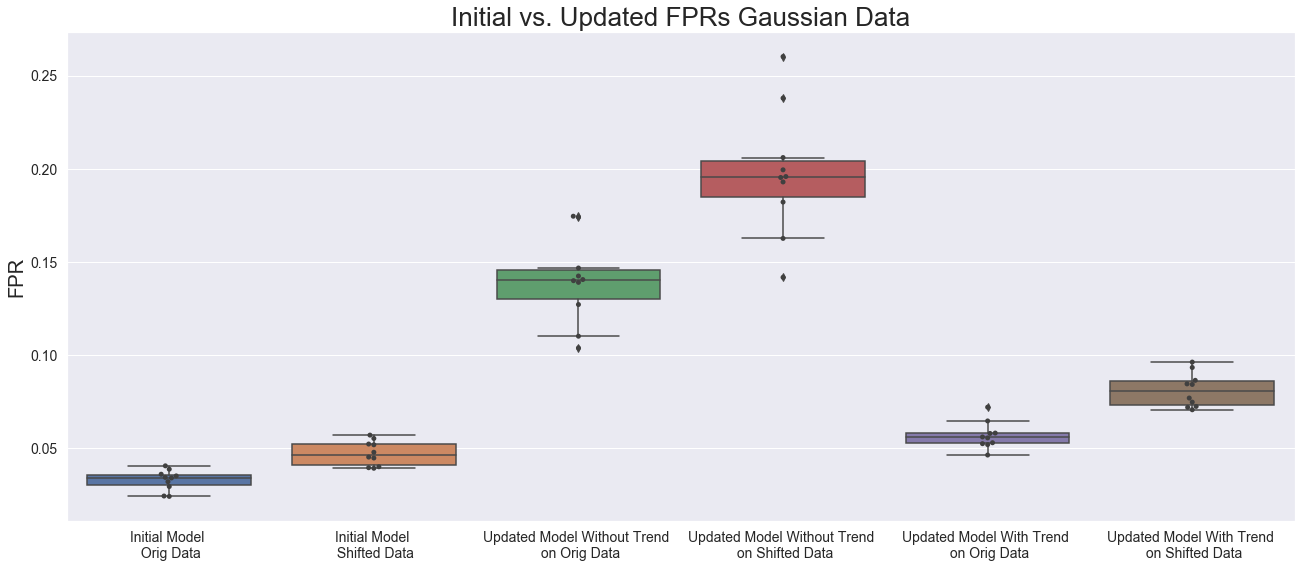

In [23]:
fig = plt.figure(figsize=(22, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs Gaussian Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

### Negative

In [24]:
offset = -3.0

In [25]:
results = train_update_loop(n_train, n_update, n_test, m0, m1, s0, s1, n_features, uniform_range, offset, seeds)

In [26]:
data = results_to_dataframe(results)

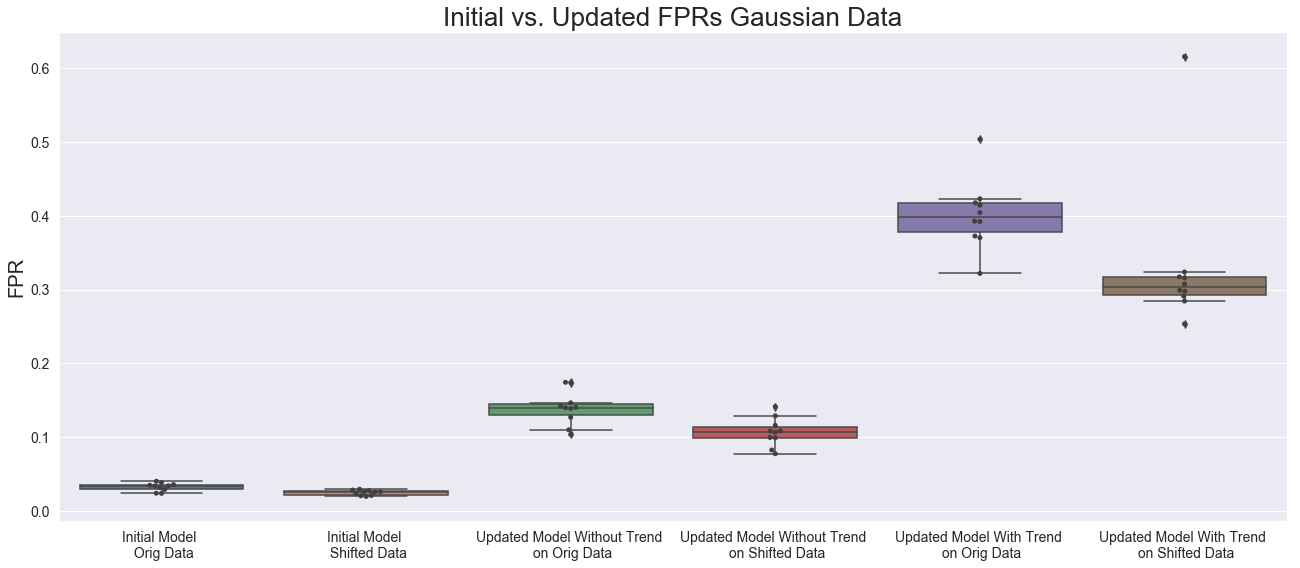

In [27]:
fig = plt.figure(figsize=(22, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs Gaussian Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)